# ドイチ-ジョサのアルゴリズム

このセクションでは、まずドイチ-ジョサ問題を紹介し、古典アルゴリズムと量子アルゴリズムによる解法を紹介します。また、Qiskitで量子アルゴリズムを実装し、シミュレーターと実デバイスでアルゴリズムの実験をします。

## 目次

1. [はじめに](#introduction)     
   1.1 [ドイチ-ジョサ問題](#djproblem)    
   1.2 [古典的な解法](#classical-solution)    
   1.3 [量子的な解法](#quantum-solution)    
   1.4 [なぜこれで機能するのか？](#why-does-this-work)     
2. [例](#example)
3. [量子オラクルの作成](#creating-quantum-oracles)     
4. [Qiskit での実装](#implementation)  
   4.1 [定値型のオラクル](#const_oracle)     
   4.2 [分布型のオラクル](#balanced_oracle)  
   4.3 [アルゴリズムの完成](#full_alg)     
   4.4 [一般化された回路](#general_circs)     
5. [実デバイスでの実験](#device)    
6. [演習問題](#problems)
7. [参考文献](#references)

## 1. はじめに <a id='introduction'></a>

ドイチ-ジョサのアルゴリズムは、古典アルゴリズムよりも優れたパフォーマンスを持つと発表された、最初の量子アルゴリズムです（参考文献[1]で最初に紹介されました）。ある特定の問題に対して量子コンピューターを使用する利点が証明された最初の量子アルゴリズムです。

### 1.1 ドイチ-ジョサ問題 <a id='djproblem'> </a>

ビット列を入力として受け取り、$0$ または$1$のいずれかを返す、以下のようなブール関数$f$があるとします。

$\hspace{15pt}
f(\{x_0,x_1,x_2,...\}) \rightarrow 0$または$1\hspace{15pt}$（ここで、$x_n$は$0$または$1$）

このブール関数の特性は、分布型か定値型かのどちらかです。定値型の場合は、任意の入力に対してすべて0またはすべて1を返しますが、分布型の場合は、半分の入力に対して0を返し、残りの半分の入力には1を返します。問題は、与えられた関数が分布型か定値型かを判断することです。

ドイチ-ジョサ問題は、1ビットであるドイチ問題のnビットへの拡張です。

### 1.2 古典的な解法 <a id='classical-solution'> </a>

古典的には、最も運が良い場合、オラクルへの2回の問い合わせで、このブール関数$f(x)$が分布型かどうかを判断できます。つまり、 $f(0,0,0,...)\rightarrow 0$で$f(1,0,0,...) \rightarrow 1$のとき、出力が異なる二つの値となるため、関数が分布型であることがわかります。

最悪の場合、つまり、何回も試行を続けても、同じ出力が示される場合、 $f(x)$ が定値型であることを確認するためには、可能な入力の総数の半分+1をチェックする必要があります。可能な入力の総数は$2^n$であるため、つまり、最悪の場合には、$f(x)$ が定値型であることを確認するために、$2^{n-1}+1$の入力を試行する必要があります。たとえば、$4$ビットの場合、$16$ の可能な組み合わせのうち$8$つをチェックして、すべて$0$を取得した場合でも、$9$番目の入力が$1$を出力し、$f(x)$が分布型である可能性があります。確率的には、これは非常にありそうもない例です。実際、同じ結果が連続して得られる場合、関数が一定である確率を$k$個の入力の関数として次のように表すことができます。

$\hspace{15pt} P_\textrm{constant}(k) = 1 - \frac{1}{2^{k-1}} \qquad\hspace{15pt}$ （ここで、$ k \leq 2^{n-1}$）

現実的には、x%の確信があると言って、計算を早期に切り捨てることを選択できます。しかし、100% の自信を持ちたい場合は、$2^{n-1}+1$ の入力をチェックする必要があります。

### 1.3 量子的な解法 <a id='quantum-solution'> </a>

量子コンピューターを使用すると、関数$f(x)$を1回呼び出すだけで、この問題を100%の信頼度で解決できます。ここで、関数$f$は、状態$\vert x\rangle \vert y\rangle $ を$ \vert x\rangle \vert y \oplus f(x)\rangle$に変換する量子オラクルで、$\oplus$ は$2$を法とする加算です。下の図はドイチ-ジョサのアルゴリズムの一般的な回路です。

![image1](images/deutsch_steps.png)

それでは、アルゴリズムの手順を見ていきましょう。

<ol>
   <li>
       2つの量子レジスターを準備します。 1つ目は$|0\rangle$に初期化された$n$量子ビットレジスターで、2つ目は$|1\rangle$に初期化された1量子ビットのレジスターです。
        

$$\vert \psi_0 \rangle = \vert0\rangle^{\otimes n} \vert 1\rangle$$


   </li>
    
   <li>
       各量子ビットにアダマールゲートを適用します。
        

$$\vert \psi_1 \rangle = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} \vert x\rangle \left(|0\rangle - |1 \rangle \right)$$


   </li>
   
   <li>
       $\vert x\rangle \vert y\rangle$を$\vert x\rangle \vert y \oplus f(x)\rangle$にする量子オラクルを適用すると、$f(x)$ は各$x$において、$0$または$1$のいずれかであるため以下のようになります。
        $$
            \begin{aligned}
            \lvert \psi_2 \rangle  
                & = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} \vert x\rangle (\vert f(x)\rangle - \vert 1 \oplus f(x)\rangle) \\  
                & = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1}(-1)^{f(x)}|x\rangle ( |0\rangle - |1\rangle ) 
        \end{aligned}
        $$
       
   </li>

   <li>
       この時点で、2番目の1量子ビットレジスターは無視できます。１番目のレジスターの各量子ビットにアダマールゲートを適用します。
        $$
        \begin{aligned}
            \lvert \psi_3 \rangle 
                & = \frac{1}{2^n}\sum_{x=0}^{2^n-1}(-1)^{f(x)}
                    \left[ \sum_{y=0}^{2^n-1}(-1)^{x \cdot y} 
                    \vert y \rangle \right] \\
                & = \frac{1}{2^n}\sum_{y=0}^{2^n-1}
                    \left[ \sum_{x=0}^{2^n-1}(-1)^{f(x)}(-1)^{x \cdot y} \right]
                    \vert y \rangle
        \end{aligned}
        $$
       
ここで、$x \cdot y = x_0y_0 \oplus x_1y_1 \oplus \ldots \oplus x_{n-1}y_{n-1}$ はビット単位の積の合計です。
   </li>

   <li>
       1番目のレジスターを測定します。 $\vert 0 \rangle ^{\otimes n} = \lvert \frac{1}{2^n}\sum_{x=0}^{2^n-1}(-1)^{f(x)} \rvert^2$の測定確率は、$f(x)$が定値型の場合は$1$に、$f(x)$が分布型の場合は$0$ になります。 
   </li>

</ol>

### 1.4 なぜこれで機能するのか？ <a id='why-does-this-work'> </a>

- **定値型のオラクル**

オラクルが*定値型*の場合、入力量子ビットからの影響を受けず（グローバル位相まで同じ）、オラクルに問い合わせする前後の量子状態は同じです。 Hゲートはそれ自体が可逆であるため、ステップ4でステップ2が逆になり、1番目のレジスターは初期量子状態の$|00\dots 0\rangle$になります。

$$
H^{\otimes n}\begin{bmatrix} 1 \\ 0 \\ 0 \\ \vdots \\ 0 \end{bmatrix} 
= 
\tfrac{1}{\sqrt{2^n}}\begin{bmatrix} 1 \\ 1 \\ 1 \\ \vdots \\ 1 \end{bmatrix}
\quad \xrightarrow{\text{after } U_f} \quad
H^{\otimes n}\tfrac{1}{\sqrt{2^n}}\begin{bmatrix} 1 \\ 1 \\ 1 \\ \vdots \\ 1 \end{bmatrix}
= 
\begin{bmatrix} 1 \\ 0 \\ 0 \\ \vdots \\ 0 \end{bmatrix} 
$$

- **分布型のオラクル**

ステップ2の後、入力レジスターはすべての計算基底の均等な重ね合わせになります。オラクルが*分布型*の場合、位相キックバックで、この半分の状態に負の位相が追加されます。

$$
U_f \tfrac{1}{\sqrt{2^n}}\begin{bmatrix} 1 \\ 1 \\ 1 \\ \vdots \\ 1 \end{bmatrix} 
= 
\tfrac{1}{\sqrt{2^n}}\begin{bmatrix} -1 \\ 1 \\ -1 \\ \vdots \\ 1 \end{bmatrix}
$$

オラクルに問い合わせをした後の量子状態は、オラクルに問い合わせをする前の量子状態と直交しています。よって、ステップ4で、Hゲートを適用すると、$|00\dots 0\rangle$に直交する量子状態になっているはずです。これは、状態がすべてゼロである結果は測定されないことを意味します。

## 2. 例  <a id='example'></a>


2ビットの分布型関数の例を見てみましょう。

<ol>
    <li> 2つの量子ビットのうち最初のレジスターは $|00\rangle$に初期化され、2番目の量子ビットレジスターは$|1\rangle$ に初期化されます（量子ビットのインデックス付けに添え字1、2、3を使用していることに注意してください。「12」の添え字は 量子ビット1と2のレジスターを意味しhます。）

$$\lvert \psi_0 \rangle = \lvert 0 0 \rangle_{12} \otimes \lvert 1 \rangle_{3} $$

 
   </li>
    
   <li> 全量子ビットにアダマールをかけます。
    

$$\lvert \psi_1 \rangle = \frac{1}{2} \left( \lvert 0 0 \rangle + \lvert 0 1 \rangle + \lvert 1 0 \rangle + \lvert 1 1 \rangle \right)_{12} \otimes \frac{1}{\sqrt{2}} \left( \lvert 0 \rangle - \lvert 1 \rangle \right)_{3}  $$

 
   </li>
    
   <li> オラクル関数は $\text{Q}_f = CX_{13}CX_{23}$　のように実装できます。 
$$
       \begin{align*}
            \lvert \psi_2 \rangle =  \frac{1}{2\sqrt{2}} \left[ \lvert 0 0 \rangle_{12} \otimes \left( \lvert 0 \oplus 0 \oplus 0 \rangle - \lvert 1 \oplus 0 \oplus 0 \rangle \right)_{3} \\
                  + \lvert 0 1 \rangle_{12} \otimes \left( \lvert 0 \oplus 0 \oplus 1 \rangle - \lvert 1 \oplus 0 \oplus 1 \rangle \right)_{3} \\
                  + \lvert 1 0 \rangle_{12} \otimes \left( \lvert 0 \oplus 1 \oplus 0 \rangle - \lvert 1 \oplus 1 \oplus 0 \rangle \right)_{3} \\
                  + \lvert 1 1 \rangle_{12} \otimes \left( \lvert 0 \oplus 1 \oplus 1 \rangle - \lvert 1 \oplus 1 \oplus 1 \rangle \right)_{3} \right]
        \end{align*}
        $$
   </li>
    
   <li>これを単純化すると、次のようになります。
       $$
       \begin{aligned}
        \lvert \psi_2 \rangle & = \frac{1}{2\sqrt{2}} \left[ \lvert 0 0 \rangle_{12} \otimes \left( \lvert 0 \rangle - \lvert 1 \rangle \right)_{3} - \lvert 0 1 \rangle_{12} \otimes \left( \lvert 0 \rangle - \lvert  1 \rangle \right)_{3} - \lvert 1 0 \rangle_{12} \otimes \left( \lvert 0  \rangle - \lvert 1 \rangle \right)_{3} + \lvert 1 1 \rangle_{12} \otimes \left( \lvert 0 \rangle - \lvert 1 \rangle \right)_{3}  \right] \\
        & = \frac{1}{2} \left( \lvert 0 0 \rangle - \lvert 0 1 \rangle - \lvert 1 0 \rangle + \lvert 1 1 \rangle \right)_{12} \otimes \frac{1}{\sqrt{2}} \left( \lvert 0 \rangle - \lvert 1 \rangle \right)_{3} \\
        & = \frac{1}{\sqrt{2}} \left( \lvert 0 \rangle - \lvert 1 \rangle \right)_{1} \otimes \frac{1}{\sqrt{2}} \left( \lvert 0 \rangle - \lvert 1 \rangle \right)_{2} \otimes \frac{1}{\sqrt{2}} \left( \lvert 0 \rangle - \lvert 1 \rangle \right)_{3}
        \end{aligned}
        $$
   </li>
    
   <li> 最初のレジスターにアダマールをかけます
        

$$ \lvert \psi_3\rangle = \lvert 1 \rangle_{1} \otimes \lvert 1 \rangle_{2} \otimes \left( \lvert 0 \rangle - \lvert 1 \rangle \right)_{3} $$


   </li>
   
   <li>  最初の2量子ビットを測定すると、ゼロ以外の$11$が得られ、分布型関数ということがわかります。
   </li>
</ol>


以下のウィジェットを使用して、この例を試すことができます。 ボタンを押してHゲートとオラクルを追加できます。`case="constant"` に設定して、セルのrestartで別のオラクルも試すことができます。

In [1]:
from qiskit_textbook.widgets import dj_widget
dj_widget(size="small", case="balanced")

HTMLMath(value='$$ |00\\rangle = |00\\rangle $$')

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01*\x00\x00\x00\xcc\x08\x06\x00\x00\x00\xc4P\xee\x0…

## 3. 量子オラクルの作成 <a id='creating-quantum-oracles'> </a>

量子オラクルを作成するいくつかの異なる方法を見てみましょう。

定値型関数の場合は簡単です。

$\qquad$ 1. f(x) = 0の場合、レジスター2の量子ビットに$I$ゲートを適用します。

$\qquad$ 2. f(x) = 1の場合、レジスター2の量子ビットに$X$ゲートを適用します。

分布型の関数の場合、複数の異なる手法で回路を作成できます。例えば、レジスター1の各量子ビットを制御ビットで、レジスター2の量子ビットをターゲットにしてCNOTを実行することで、回路が分布型であることを保証できます。 例：

![image2](images/deutsch_balanced1.svg)

上の回路図では、上の3つの量子ビットが入力レジスターで、一番下の量子ビットが出力レジスターです。 以下の表で、どの入力状態がどの出力を与えるかを確認できます。

| 出力0となる入力状態 | 出力1となる入力状態 |
|:--------------------------:|:--------------------------:|
|             000            |             001            |
|             011            |             100            |
|             101            |             010            |
|             110            |             111            |


制御ビットをXゲートでラップすることにより、分布型であることを保ちながら結果を変更できます。 たとえば、次の回路とその結果の表を確認してください。

![other_balanced_circuit](images/deutsch_balanced2.svg)

| 出力0となる入力状態 | 出力1となる入力状態 |
|:--------------------------:|:--------------------------:|
|             001            |             000            |
|             010            |             011            |
|             100            |             101            |
|             111            |             110            |

## 4. Qiskit での実装 <a id='implementation'></a>

ここで、例として3ビット関数でドイチ-ジョサのアルゴリズムを実装します。定値型のオラクルと分布型のオラクルの両方を実装します。 まず、必要なモジュールのインポートから始めます。

In [2]:
# initialization
import numpy as np

# importing Qiskit
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, execute

# import basic plot tools
from qiskit.visualization import plot_histogram

次にオラクルの入力レジスターのサイズをセットします。

In [3]:
# set the length of the n-bit input string. 
n = 3

### 4.1 定値型オラクル <a id='const_oracle'></a>
定値型オラクルから作ります。定値型は、入力は出力に影響を与えないため、出力量子ビットは0または1にランダムに設定します。

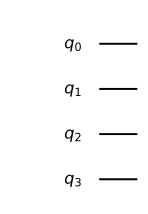

In [4]:
# set the length of the n-bit input string. 
n = 3

const_oracle = QuantumCircuit(n+1)

output = np.random.randint(2)
if output == 1:
    const_oracle.x(n)

const_oracle.draw()

### 4.2 分布型オラクル <a id='balanced_oracle'></a>

In [5]:
balanced_oracle = QuantumCircuit(n+1)

次に、分布型オラクルを作ります。 1bの節で見たように、各入力量子ビットを制御ビット、出力ビットをターゲットビットとしてCNOTを実装することで、分布型オラクルを作成できます。 一部の制御ビットをXゲートでラップすることにより、0または1を出力する入力状態の変更ができます。 まず、ラップする制御ビットを指定する長さ`n` のバイナリー文字列をセットします。

In [6]:
b_str = "101"

この文字列を、Xゲートを配置するためのキーとして使用します。 各量子ビットについて、`b_str`の対応する桁が`1`の場合はXゲートを置き、 `0`の場合は何も置きません

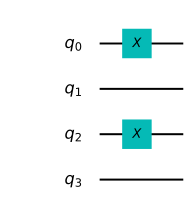

In [7]:
balanced_oracle = QuantumCircuit(n+1)
b_str = "101"

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)
balanced_oracle.draw()

次に、各入力量子ビットを制御ビットとし、出力量子ビットをターゲットビットとして、制御NOTゲートを実装します。

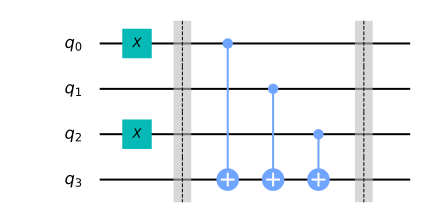

In [8]:
balanced_oracle = QuantumCircuit(n+1)
b_str = "101"

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

# Use barrier as divider
balanced_oracle.barrier()

# Controlled-NOT gates
for qubit in range(n):
    balanced_oracle.cx(qubit, n)

balanced_oracle.barrier()
balanced_oracle.draw()

最後に、2つのセルからコードを繰り返して、制御ビットをXゲートでラップします。

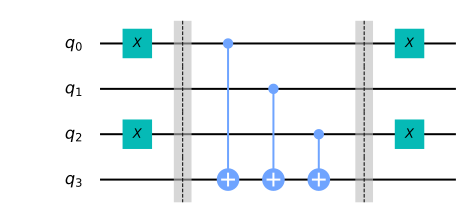

In [9]:
balanced_oracle = QuantumCircuit(n+1)
b_str = "101"

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

# Use barrier as divider
balanced_oracle.barrier()

# Controlled-NOT gates
for qubit in range(n):
    balanced_oracle.cx(qubit, n)

balanced_oracle.barrier()

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

# Show oracle
balanced_oracle.draw()


分布型オラクルを作成できました。 あとは、ドイチ-ジョサのアルゴリズムがこの問題を解くことができるか確認するだけです。

### 4.3 アルゴリズムの完成 <a id='full_alg'></a>

それでは、すべてをまとめましょう。 アルゴリズムの最初のステップは、入力量子ビットを状態$|{+}\rangle$ に、出力量子ビットを状態$|{-}\rangle$に初期化することです。

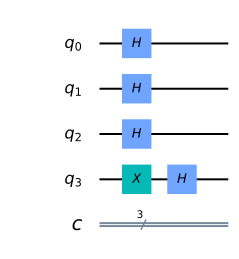

In [10]:
dj_circuit = QuantumCircuit(n+1, n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n)
dj_circuit.draw()

次に、オラクルを適用しましょう。ここでは、上記で作成した`balanced_oracle` を適用します。

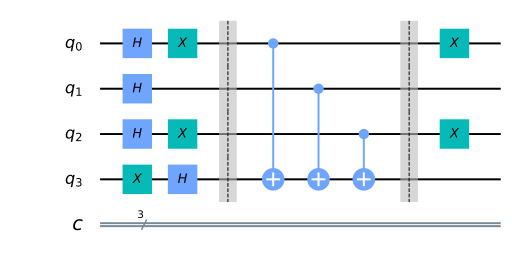

In [11]:
dj_circuit = QuantumCircuit(n+1, n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n)

# Add oracle
dj_circuit += balanced_oracle
dj_circuit.draw()


最後に、 $n$個の入力量子ビットにHゲートを適用し、入力レジスターを測定します。

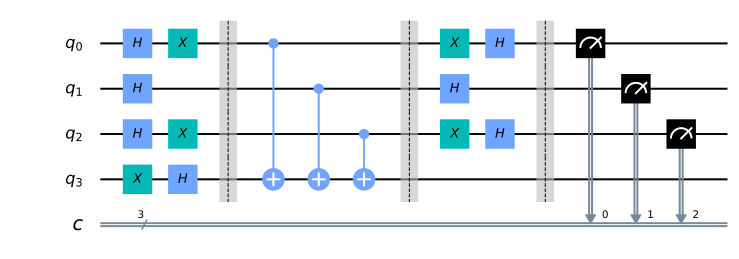

In [12]:
dj_circuit = QuantumCircuit(n+1, n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n)

# Add oracle
dj_circuit += balanced_oracle

# Repeat H-gates
for qubit in range(n):
    dj_circuit.h(qubit)
dj_circuit.barrier()

# Measure
for i in range(n):
    dj_circuit.measure(i, i)

# Display circuit
dj_circuit.draw()

出力を見てみましょう：

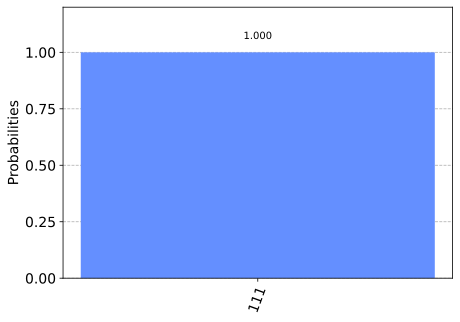

In [13]:
# use local simulator
backend = BasicAer.get_backend('aer_simulator')
shots = 1024
results = execute(dj_circuit, backend=backend, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

上記の結果から、`000`を測定する可能性は0％であることがわかります。これにより、関数が分布型であることが正しく予測されます。

### 4.4 一般化された回路 <a id='general_circs'></a>

次のコードは、一般化されたドイチ-ジョサのオラクルを作成し、量子ゲートに変換する関数です。`case`で分布型か定値型かを区別し（`'balanced'`または `constant`）、また `n`は入力レジスターのサイズです：

In [14]:
def dj_oracle(case, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)
    
    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1,2**n)
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit 
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle" # To show when we display the circuit
    return oracle_gate

このオラクルのゲートを入力して、ドイチ-ジョサのアルゴリズムを実行する関数も作成しましょう。

In [15]:
def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
    # Let's append the oracle gate to our circuit:
    dj_circuit.append(oracle, range(n+1))
    # Finally, perform the H-gates again and measure:
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

最後に、これらの関数を使用してアルゴリズムを試してみましょう。

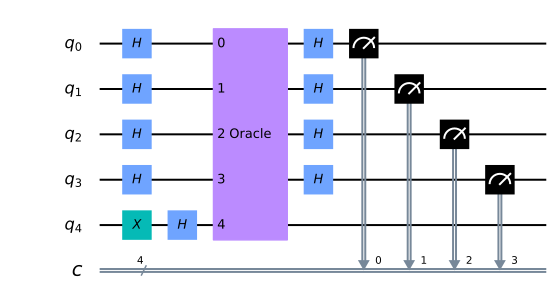

In [16]:
n = 4
oracle_gate = dj_oracle('balanced', n)
dj_circuit = dj_algorithm(oracle_gate, n)
dj_circuit.draw()

この回路を実行した結果を見てみます。

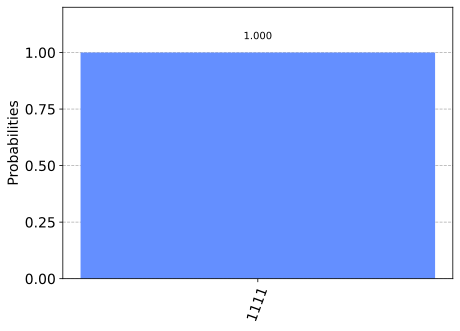

In [17]:
results = execute(dj_circuit, backend=backend, shots=1024).result()
answer = results.get_counts()
plot_histogram(answer)

## 5. 実デバイスでの実験 <a id='device'></a>

実デバイスでの回路の実行は、以下のようにして行います。まず、この回路が実行可能で最も空いているデバイスを探します。

In [18]:
# Load our saved IBMQ accounts and get the least busy backend device with greater than or equal to (n+1) qubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n+1) and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_athens


In [19]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

shots = 1024
job = execute(dj_circuit, backend=backend, shots=shots, optimization_level=3)

job_monitor(job, interval = 2)

Job Status: job has successfully run


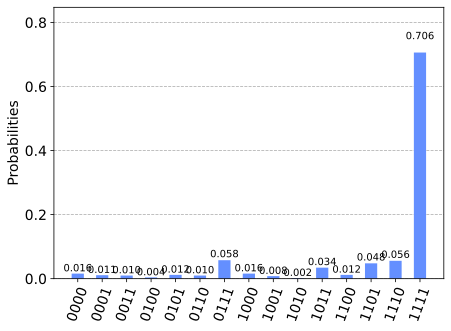

In [20]:
# Get the results of the computation
results = job.result()
answer = results.get_counts()

plot_histogram(answer)

ご覧のとおり、最も可能性の高い結果は`1111`です。他の結果は、量子計算の誤差によるものです。

## 6. 演習問題 <a id='problems'></a>

1. 異なる形の分布型、定値型のオラクルを作成できますか？

In [21]:
from qiskit_textbook.problems import dj_problem_oracle
oracle = dj_problem_oracle(1)



2. 上記の関数`dj_problem_oracle`は、`n = 4`のドイチ-ジョサオラクルをゲートの形式で返します。ゲートの入力は5量子ビットで、最後の量子ビット（`q_4`）が出力量子ビットです（上記のオラクルの例のように）。 `dj_problem_oracle` に1〜5の異なる整数を指定することで、異なるオラクルを取得できます。ドイチ-ジョサのアルゴリズムを使用して、各オラクルが分布型か定値型かを判断してください（**注**：実デバイスではなく、`aer_simulator`を使用して試すことを強くお勧めします） 。

## 7. 参考文献 <a id='references'></a>

1. David Deutsch and Richard Jozsa (1992). "Rapid solutions of problems by quantum computation". Proceedings of the Royal Society of London A. 439: 553–558.  [doi:10.1098/rspa.1992.0167](https://doi.org/10.1098%2Frspa.1992.0167).
2. R. Cleve; A. Ekert; C. Macchiavello; M. Mosca (1998). "Quantum algorithms revisited". Proceedings of the Royal Society of London A. 454: 339–354. [doi:10.1098/rspa.1998.0164](https://doi.org/10.1098%2Frspa.1998.0164).

In [22]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.14.2',
 'qiskit-aer': '0.5.2',
 'qiskit-ignis': '0.3.3',
 'qiskit-ibmq-provider': '0.7.2',
 'qiskit-aqua': '0.7.3',
 'qiskit': '0.19.6'}